In [1]:
import sqlite3
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

params = {
    'axes.labelsize'  : 15.5,
    "font.family": "sans-serif",
    'axes.titlesize'  : 'medium',
    'font.size'       : 14,
    'legend.fontsize' : 14,
    'xtick.labelsize' : 'small',
    'ytick.labelsize' : 'small'
}
plt.rcParams.update(params)

In [2]:
latest_file_timestamp = '20211010-151010'
latest_time = '2021-10-10'

PATH_DEMOGRAPHICS = f"postgres/{latest_file_timestamp}_participant_data.csv"

In [3]:
q_respondents_with_submissions = '''
    select session_id, min(first_interaction_time)
    from interactionswithmask
    group by session_id
    order by min(first_interaction_time) ASC
'''

conn = sqlite3.connect('grabcutstudy.db')
interactions_with_submissions_df = pd.read_sql_query(
    q_respondents_with_submissions,
    conn
)

conn.close()

In [4]:
interactions_with_submissions_df = interactions_with_submissions_df.rename(columns={
    'min(first_interaction_time)': 'participation_time'
})

padded_timeline_df = pd.DataFrame(pd.date_range(start='2021-09-16', end=latest_time, freq='D'), columns=['padded_time'])

interactions_with_submissions_df['participation_time'] = pd.to_datetime(interactions_with_submissions_df['participation_time'])
interactions_with_submissions_df['participation_time'] = interactions_with_submissions_df['participation_time'].dt.floor('D')

In [5]:
len(interactions_with_submissions_df)

75

In [6]:
respondents_df = pd.read_csv(PATH_DEMOGRAPHICS)
respondents_df = respondents_df.rename(columns={
    'id': 'participant_uuid',
})

In [7]:
respondents_with_submissions_df = pd.merge(respondents_df, interactions_with_submissions_df, on='session_id', how='inner')
respondents_timeline_df = pd.merge(respondents_with_submissions_df, padded_timeline_df, how='outer', left_on='participation_time', right_on='padded_time')

respondents_timeline_df.drop('participation_time', axis=1, inplace=True)
respondents_timeline_df.rename(columns={'padded_time': 'participation_time'}, inplace=True)
respondents_timeline_df['year'] = respondents_timeline_df['participation_time'].dt.year.astype('int32')
respondents_timeline_df['month'] = respondents_timeline_df['participation_time'].dt.month.astype('int32')
respondents_timeline_df['day'] = respondents_timeline_df['participation_time'].dt.day.astype('int32')
respondents_timeline_df = respondents_timeline_df.fillna("")

In [8]:
def is_empty_string(x):
    if x == '': return 0
    else: return 1

respondents_timeline_df['access'] = respondents_timeline_df['session_id'].apply(is_empty_string)

In [9]:
participation_timeline_grouped_df = respondents_timeline_df.groupby(['year', 'month', 'day']).sum().reset_index()
participation_timeline_grouped_df['date'] = pd.to_datetime(participation_timeline_grouped_df[['year', 'month', 'day']]).dt.strftime('%m-%d')

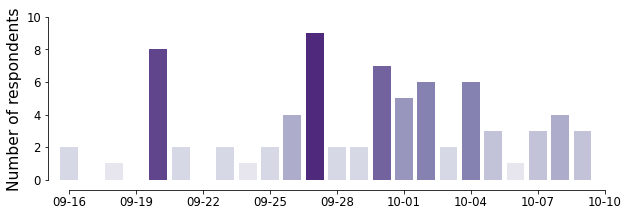

In [10]:
sns.set_style({
    'palette': sns.dark_palette("crimson", reverse=True, as_cmap=True),
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(10, 3))

sns.barplot(
    x="date", y="access", data=participation_timeline_grouped_df, dodge=False, hue="access", palette="Purples",
)

ax.set(xlabel="")
ax.set(ylabel="Number of respondents")

ax.set_ylim([0, 10])

# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_xlim([0.9, 1000])

sns.despine(offset=10, trim=True)

dates = participation_timeline_grouped_df['date'].values.tolist()
new_labels = [
    '' if i % 3 != 0 else elt for i, elt in enumerate(dates)]
ax.set_xticklabels(new_labels)

i = 0
for t in ax.xaxis.get_ticklines()[::1]:
    if i % 3 != 0:
        t.set_visible(False)
    i = i + 1

plt.legend([],[], frameon=False)
plt.savefig(f"plots/respondents_activity.png", bbox_inches='tight')
plt.show()

In [11]:
respondents_background_df = respondents_with_submissions_df.groupby('academic_field').size().reset_index(name='counts')
respondents_background_df.sort_values(by='counts', inplace=True, ascending=False)

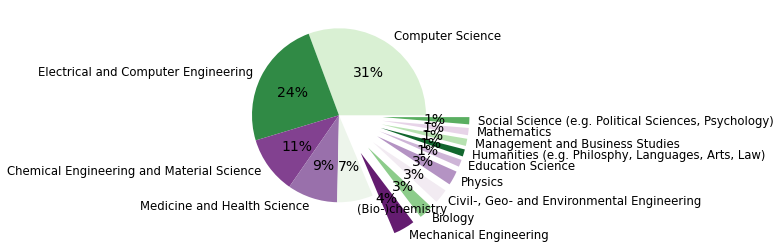

In [12]:
academ_bg_palette = sns.color_palette("PRGn", len(respondents_background_df))
colors_academ_background = academ_bg_palette[0:]
np.random.shuffle(colors_academ_background)

explode = np.zeros(len(respondents_background_df))
explode[-9:] = 0.5
explode = tuple(explode)

labels = respondents_background_df.academic_field.values
counts = respondents_background_df.counts.values

plt.pie(counts, labels=labels, colors=colors_academ_background, autopct='%.0f%%', explode=explode)
plt.show()

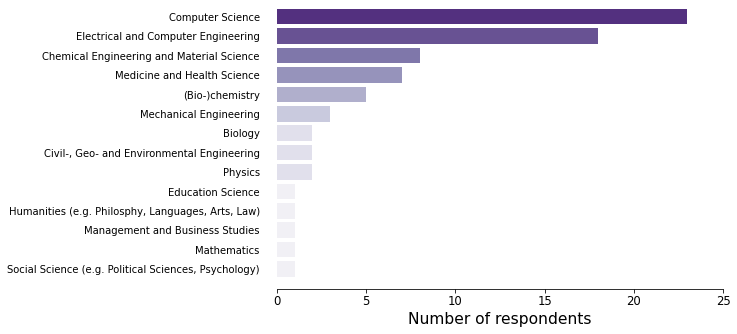

In [13]:
sns.set_style({
    'xtick.top': False,
    'ytick.left': False,
    'ytick.right': False,
    'axes.spines.left': False,
})

f, ax = plt.subplots(figsize=(8, 5))

b = sns.barplot(
    x="counts", y="academic_field", data=respondents_background_df, dodge=False, hue="counts", palette="Purples",
)

ax.set(xlabel="Number of respondents")
ax.set(ylabel="")

# ax.set_ylim([0, 10])

# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlim([0, 25])

sns.despine(offset=10, trim=True)

ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', labelsize=10)

plt.legend([],[], frameon=False)
plt.savefig(f"plots/respondents_academic_bg.png", bbox_inches='tight')

plt.show()

In [14]:
age_ranges = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', 'Above 64']
age_ranges_df = pd.DataFrame.from_dict({'age_group': age_ranges})

age = pd.api.types.CategoricalDtype(ordered=True, categories=age_ranges)
respondents_age_df = respondents_with_submissions_df.groupby('age_group').size().reset_index(name='counts')
respondents_age_df = respondents_age_df.assign(age_group=respondents_age_df['age_group'].astype(age))

In [15]:
respondents_age_padded_df = pd.merge(respondents_age_df, age_ranges_df, on='age_group', how='outer')
respondents_age_padded_df = respondents_age_padded_df.fillna(0)

respondents_age_padded_df = respondents_age_padded_df.assign(image_id=respondents_age_padded_df['age_group'].astype(age))

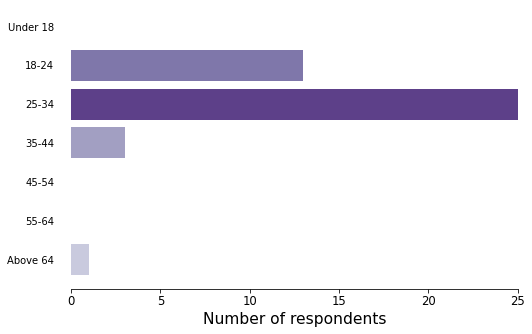

In [16]:
sns.set_style({
    'xtick.top': False,
    'ytick.left': False,
    'ytick.right': False,
    'axes.spines.left':   False
})

f, ax = plt.subplots(figsize=(8, 5))

b = sns.barplot(
    x="counts", y="age_group", data=respondents_age_padded_df, dodge=False, hue="counts", palette="Purples",
    order=age_ranges
)

ax.set(xlabel="Number of respondents")
ax.set(ylabel="")

# ax.set_ylim([0, 10])

# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlim([0, 25])

sns.despine(offset=10, trim=True)

ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', labelsize=10)

plt.legend([],[], frameon=False)
plt.savefig(f"plots/respondents_ages.png", bbox_inches='tight')
plt.show()